## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from scipy.spatial import distance

На всякий случай, приведу здесь использованную при решении задания версию sklearn, поскольку импорт
```python
from sklearn.datasets import fetch_mldata
```
не работает, я заменил его на
```python
from sklearn.datasets import fetch_openml
```
Версия sklearn: 1.0.2

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    """
    Realization of kNN classifier
    """
    def __init__(self, n_neighbors, algorithm='brute', leaf_size=30):        
        self.__n_neighbors = n_neighbors
        self.__algorithm = algorithm
        self.__leaf_size = 30
        self._tree = None
    
    @property
    def n_neighbors(self):
        return self.__n_neighbors
    
    @property
    def algorithm(self):
        return self.__algorithm
    
    @property
    def leaf_size(self):
        return self.__leaf_size
    
    def fit(self, X, y):
        self.__X_train = X
        self.__y_train = y
        if self.algorithm == 'kd_tree':
            self.__tree = KDTree(X, leaf_size=self.leaf_size)
            
        
    def predict(self, X):
        predicts = np.zeros((X.shape[0]), dtype='int')

        if self.algorithm == 'brute':        
            for i, x in enumerate(X):
                distances = distance.cdist(self.__X_train, x.reshape(1, -1)).flatten()
                nn_indices = np.argsort(distances)[:self.n_neighbors]
                label = np.argmax(np.bincount(self.__y_train[nn_indices]))
                predicts[i] = label
        elif self.algorithm == 'kd_tree':
            indices = self.__tree.query(X, k=self.n_neighbors, return_distance=False)
            for i, idx in enumerate(indices):
                label = np.argmax(np.bincount(self.__y_train[idx]))
                predicts[i] = label
        
        return predicts

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs(accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred)) < 0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 565 µs, sys: 135 µs, total: 700 µs
Wall time: 607 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 11.9 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 2.99 ms, sys: 2.15 ms, total: 5.14 ms
Wall time: 3.28 ms


array([1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 2, 2, 0, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 1.79 ms, sys: 1.49 ms, total: 3.28 ms
Wall time: 1.98 ms


array([1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 2, 2, 0, 2])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 1.18 ms, sys: 1.36 ms, total: 2.54 ms
Wall time: 3.2 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 236 µs, sys: 21 µs, total: 257 µs
Wall time: 243 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 2.72 ms, sys: 1.67 ms, total: 4.39 ms
Wall time: 3.69 ms


array([0, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 1, 1, 2, 1])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 891 µs, sys: 957 µs, total: 1.85 ms
Wall time: 1.04 ms


array([0, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 1, 1, 2, 1])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs(accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred)) < 0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train', remove=['headers', 'footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
# преобразование данных я буду выполнять на ходу во время grid-search

count_vec = CountVectorizer(max_df=0.8, min_df=10, stop_words='english')
tf_idf = TfidfVectorizer(max_df=0.8, min_df=10, stop_words='english')

data, target = np.array(data), np.array(target)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
# в используемой версии sklearn есть только KFold - он возвращает итератор
kf = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
# функция для grid-search
def knn_cv_score(X, y, parameters, score_function, kf, knn_class):
    cv_score = defaultdict(list)

    for train, val in kf.split(X):
        for normalizer, normalizer_name in parameters['normalizers']:
            X_train, X_val = X[train], X[val]
            y_train, y_val = y[train], y[val]

            normalizer.fit(X_train)
            X_train = normalizer.transform(X_train)
            X_val = normalizer.transform(X_val)

            for n_neighbors in parameters['n_neighbors']:
                for metric in parameters['metrics']:
                    knn_model = knn_class(n_neighbors=n_neighbors, metric=metric)
                    knn_model.fit(X_train, y_train)
                    y_val_predict = knn_model.predict(X_val)
                    score = score_function(y_val, y_val_predict)
                    cv_score[(normalizer_name, n_neighbors, metric)].append(score)

    for params in cv_score:
        cv_score[params] = np.mean(cv_score[params])

    return dict(cv_score)

In [24]:
# сразу включаю в параметры и косинусную метрику, и TfIdf векторизацию для последующего сравнения
parameters = {
    'n_neighbors': [i for i in range(1, 11)],
    'metrics': ['euclidean', 'cosine'],
    'normalizers': [(count_vec, 'CountVectorizer'), (tf_idf, 'TfidfVectorizer')]
}

In [25]:
%%time
cv_score = knn_cv_score(data, target, parameters, accuracy_score, kf, KNeighborsClassifier)

CPU times: user 2min 18s, sys: 40 s, total: 2min 58s
Wall time: 3min 8s


In [26]:
max_index = max(cv_score, key=cv_score.get)
print(f'Best cv parameters: {max_index}, Best cv accuracy score: {cv_score[max_index]}')

Best cv parameters: ('TfidfVectorizer', 10, 'cosine'), Best cv accuracy score: 0.6280721444065466


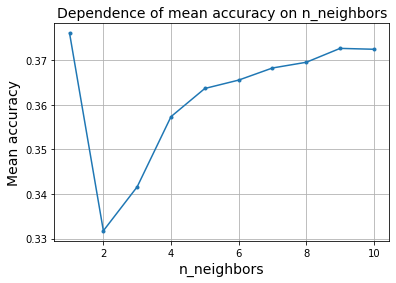

In [27]:
score_n_neighbors = []
for n_neighbors in parameters['n_neighbors']:
    cv_mean_n_neighbors = np.mean([cv_score[params] for params in cv_score if n_neighbors in params])
    score_n_neighbors.append(cv_mean_n_neighbors)


plt.plot(parameters['n_neighbors'], score_n_neighbors, marker='.')
plt.xlabel("n_neighbors", fontsize=14)
plt.ylabel("Mean accuracy", fontsize=14)
plt.title("Dependence of mean accuracy on n_neighbors", fontsize=14)

plt.grid(True)

plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

### Сравнение метрик близости

In [28]:
for metric in parameters['metrics']:
    cv_mean_metric = np.mean([cv_score[params] for params in cv_score if metric in params])
    print(metric + ':', cv_mean_metric)

euclidean: 0.16976292254361788
cosine: 0.5539776907618269


Косинусная близость в среднем лучше. Это из-за того, что сонаправленность векторов встречаемости токенов важнее чем разность их величин.

### Сравнение векторизаторов

In [29]:
for normalizer, norm_name in parameters['normalizers']:
    cv_mean_normalizer = np.mean([cv_score[params] for params in cv_score if norm_name in params])
    print(norm_name + ':', cv_mean_normalizer)

CountVectorizer: 0.3743414339343836
TfidfVectorizer: 0.3493991793710612


Если сравнивать, усредняя по всем параметрам, то CountVectorizer показывает себя лучше. Однако, если усреднять только по тем параметрам, где использовалась косинусная метрика близости:

In [30]:
for normalizer, norm_name in parameters['normalizers']:
    cv_mean_normalizer = np.mean(
        [cv_score[params] for params in cv_score if norm_name in params and 'cosine' in params]
    )
    print(norm_name + ':', cv_mean_normalizer)

CountVectorizer: 0.5140533807192037
TfidfVectorizer: 0.59390200080445


то оказывается, что в среднем лучше TfidfVectorizer. Если токен встречается в большом числе документов, то он менее информативен для определения класса конкретного документа и, наоборот. TF_IDF учитывает это, CountVectorizer - нет.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [31]:
newsgroups = fetch_20newsgroups(subset='test', remove=['headers', 'footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [32]:
X_test, y_test = np.array(newsgroups['data']), np.array(newsgroups['target'])

In [33]:
# scaling data with TfidfVectorizer
tf_idf = TfidfVectorizer(max_df=0.8, min_df=10, stop_words='english')
tf_idf.fit(data)
X_train_scaled = tf_idf.transform(data)
X_test_scaled = tf_idf.transform(X_test)

# training model on best cv parameters
best_cv_model = KNeighborsClassifier(n_neighbors=10, metric='cosine')
best_cv_model.fit(X_train_scaled, target)

# getting predictions
y_test_predict = best_cv_model.predict(X_test_scaled)
test_score = accuracy_score(y_test, y_test_predict)
print(f'Accuracy on test: {test_score}')

Accuracy on test: 0.580987785448752


Качество немного хуже лучшего на кросс-валидации, поскольку теперь модель обучалась помимо того, что на обучающей выборке целиком, так и скорее всего, токены в обучающей и тестовой выборке имеют разное распределение, поэтому нам не гарантировано получение того же качества, что и на кросс-валидации.